В датасете представлены следующие данные:

* Bar id — ID батончика в базе данных
* Company (Maker-if known) — название компании, изготовившей батончик.
* Specific Bean Origin or Bar Name — точное место происхождения какао-бобов.
* Broad Bean Origin — название региона, где были выращены какао-бобы.
* Company Location — страна, в которой произведён шоколадный батончик.
* Bean Type — вид какао-бобов, используемых в батончике.
* REF — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.
* Review Date — год публикации рецензии.
* Cocoa Percent — процент какао в шоколаде.
* Rating — оценка батончика фокус-группой

#### 2.2. Первичный отсмотр данных

Импортируем нужные для чтения и первичного анализа библиотеки и прочитаем файл:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

cacao = pd.read_csv('cacao_flavors.csv')
%matplotlib inline

In [5]:
print(cacao.head(10))
cacao.info()
cacao.describe()

   Bar id Company \n(Maker-if known) Specific Bean Origin\nor Bar Name   REF  \
0       1                   A. Morin                       Agua Grande  1876   
1       2                   A. Morin                             Kpime  1676   
2       3                   A. Morin                            Atsane  1676   
3       4                   A. Morin                             Akata  1680   
4       5                   A. Morin                            Quilla  1704   
5       6                   A. Morin                          Carenero  1315   
6       7                   A. Morin                              Cuba  1315   
7       8                   A. Morin                      Sur del Lago  1315   
8       9                                               Puerto Cabello  1319   
9      10                   A. Morin                           Pablino  1319   

   Review\nDate Cocoa\nPercent Company\nLocation  Rating Bean\nType  \
0          2016            63%            France

,Bar id,REF,Review Date,Rating
count,1795.000000,1795.000000,1795.000000,1795.000000
mean,898.000000,1035.904735,2012.325348,3.422981
std,518.316184,552.886365,2.927210,1.750584
min,1.000000,5.000000,2006.000000,1.000000
25%,449.500000,576.000000,2010.000000,3.000000
50%,898.000000,1069.000000,2013.000000,3.250000
75%,1346.500000,1502.000000,2015.000000,3.500000
max,1795.000000,1952.000000,2017.000000,19.750000


##### 2.3. Первичный анализ данных в столбцах. Часть I

Для удобства использования pandas переименуем все столбцы:

In [9]:
cacao.columns = ['bar_id','company','specific_origin','ref','review_date','cocoa_percent','company_location','rating','bean_type','broad_origin']
cacao.columns

Index(['bar_id', 'company', 'specific_origin', 'ref', 'review_date',
       'cocoa_percent', 'company_location', 'rating', 'bean_type',
       'broad_origin'],
      dtype='object')

Теперь рассмотрим все 10 столбцов по отдельности.

### Bar id

1795


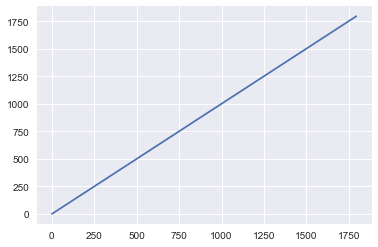

In [10]:
print(cacao.bar_id.nunique())
plt.plot(cacao.bar_id)

Тут все просто: это столбец индексов батончиков, количество уникальных значений соответствует количеству строк. Вряд ли он пригодится для дальнейшего анализа, удалим его.

In [11]:
cacao.drop(['bar_id'], inplace = True, axis = 1)

### Company

Посмотрим, сколько компаний содержит наш датасет.

In [12]:
pd.DataFrame(cacao.company.value_counts())
cacao.company.value_counts()

                              99
Soma                          45
Fresco                        26
Bonnat                        26
Pralus                        25
Domori                        22
Valrhona                      21
A. Morin                      21
Arete                         20
Hotel Chocolat (Coppeneur)    18
Guittard                      18
Scharffen Berger              17
Zotter                        17
Dandelion                     16
Mast Brothers                 16
Coppeneur                     16
Rogue                         16
Szanto Tibor                  15
Smooth Chocolator, The        15
Castronovo                    14
Bittersweet Origins           13
Pierre Marcolini              13
Duffy's                       13
Artisan du Chocolat           13
Tejas                         12
                              ..
Whittakers                     1
Glennmade                      1
Indi                           1
Pangea                         1
Cacao Mark



Попробуем отфильтровать лишние данные и выведем только те компании, у которых в рейтинге больше 10 продуктов.

In [13]:
cacao.company = cacao.company.apply(lambda x: None if x.strip() == '' else x)

print(pd.DataFrame(cacao.company.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:" ,(cacao.company.value_counts()>10).sum()) #Число 10 взято для ориентира, можно брать другое, 
cacao.loc[:, ['company']].info()

                                     company
Soma                                      45
Fresco                                    26
Bonnat                                    26
Pralus                                    25
Domori                                    22
A. Morin                                  21
Valrhona                                  21
Arete                                     20
Hotel Chocolat (Coppeneur)                18
Guittard                                  18
Zotter                                    17
Scharffen Berger                          17
Rogue                                     16
Dandelion                                 16
Coppeneur                                 16
Mast Brothers                             16
Szanto Tibor                              15
Smooth Chocolator, The                    15
Castronovo                                14
Pierre Marcolini                          13
Duffy's                                   13
Bitterswee

Итого у нас 407 уникальных значений и 99 строк, в которых производитель неизвестен. А вот компаний, у которых в рейтинге больше 10 батончиков, всего 30. Заполнить пропуски на данный момент не представляется возможным, так как вариантов для заполнения слишком много.

### specific_origin
Сделаем то же самое для столбца с местом происхождения какао-бобов. 

Сколько уникальных регионов в датасете?

In [14]:
cacao.specific_origin.apply(lambda x: None if x.strip() == '' else x).value_counts()


Madagascar                                      55
Peru                                            44
Ecuador                                         39
Dominican Republic                              33
Venezuela                                       21
Sambirano                                       18
Chuao                                           18
Ocumare                                         16
Papua New Guinea                                15
Ghana                                           15
Belize                                          13
Bolivia                                         12
Brazil                                          11
La Red                                          11
Tanzania                                        11
Porcelana                                       10
Trinidad                                        10
Costa Rica                                      10
Carenero Superior                               10
Maya Mountain                  

Сколько значений, встретившихся в столбце более 10 раз?

In [15]:
#cacao.specific_origin = cacao.specific_origin.apply(lambda x: None if x.strip() == '' else x)

(cacao.specific_origin.value_counts()>10).sum()

16

### ref

Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:

count    1795.000000
mean     1035.904735
std       552.886365
min         5.000000
25%       576.000000
50%      1069.000000
75%      1502.000000
max      1952.000000
Name: ref, dtype: float64

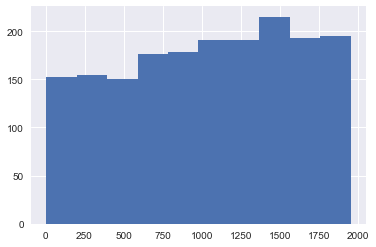

In [16]:
cacao.ref.hist()
cacao.ref.describe()

Как видно, у этого признака распределение без аномалий, выбросов нет. Заметен тренд на возрастание количества отзывов со временем (так как REF обозначает время внесения отзыва в базу). Интересно, почему так происходит?

### review_date
Этот столбец также числовой и у него также нет пропусков. Как ведет себя распределение этого признака?

count    1795.000000
mean     2012.325348
std         2.927210
min      2006.000000
25%      2010.000000
50%      2013.000000
75%      2015.000000
max      2017.000000
Name: review_date, dtype: float64

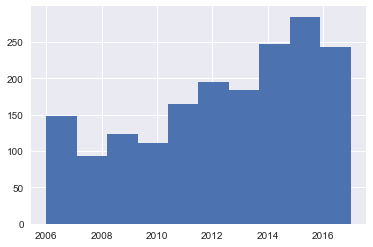

In [17]:
cacao.review_date.hist()
cacao.review_date.describe()

Здесь также заметен тренд на увеличение ревью со временем.

### cocoa_percent
Посмотрим на данные в столбце:

In [18]:
cacao.cocoa_percent

0        63%
1        70%
2       670%
3        70%
4        70%
5        70%
6        70%
7        70%
8        70%
9        70%
10       70%
11       70%
12       70%
13       70%
14       70%
15       70%
16       70%
17       70%
18       70%
19       70%
20       63%
21       70%
22       63%
23       70%
24       70%
        ... 
1770     85%
1771     70%
1772     78%
1773     78%
1774     65%
1775     68%
1776     66%
1777     72%
1778     80%
1779     72%
1780     65%
1781     70%
1782     70%
1783     62%
1784     75%
1785    375%
1786     90%
1787     70%
1788     68%
1789     58%
1790     70%
1791     65%
1792     65%
1793     62%
1794     65%
Name: cocoa_percent, Length: 1795, dtype: object

Значения в столбцах представлены в виде процентов. Для дальнейшего анализа будет проще, если они будут представлены числами. Трансформируем столбец:

In [20]:
cacao.cocoa_percent = cacao.cocoa_percent.apply(lambda x: float(x.replace('%', '')))

Посмотрим распределение признака:

count    1795.000000
mean       75.932312
std        44.475981
min        42.000000
25%        70.000000
50%        70.000000
75%        75.000000
max       682.000000
Name: cocoa_percent, dtype: float64

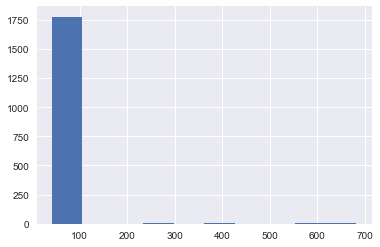

In [21]:
cacao.cocoa_percent.hist()
cacao.cocoa_percent.describe()

Видим, что основное распределение лежит между  и  процентами и есть потенциальные выбросы свыше % (об этом нам говорит здравый смысл).

Самый простой способ отфильтровать выбросы — воспользоваться формулой интерквартильного расстояния (межквартильного размаха). Выбросом считаются такие значения, которые лежат вне рамок

[percentile(25) -1.5*IQR : percentile(75)+1.5*IQR],
где IQR = percentile(75) - percentile(25).

25-й перцентиль: 70.0, 75-й перцентиль: 75.0, IQR: 5.0,  Границы выбросов: [62.5, 82.5].


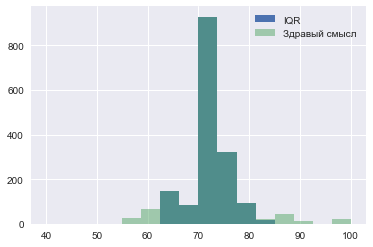

In [22]:
IQR = cacao.cocoa_percent.quantile(0.75) - cacao.cocoa_percent.quantile(0.25)
perc25 = cacao.cocoa_percent.quantile(0.25)
perc75 = cacao.cocoa_percent.quantile(0.75)
 
print(
'25-й перцентиль: {},'.format(perc25),
'75-й перцентиль: {},'.format(perc75),
"IQR: {}, ".format(IQR),
"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
cacao.cocoa_percent.loc[cacao.cocoa_percent.between(
perc25 - 1.5*IQR,
perc75 + 1.5*IQR)].hist(bins = 16, range = (40, 100), label = 'IQR')
 
cacao.cocoa_percent.loc[cacao.cocoa_percent <= 100].hist(
alpha = 0.5, bins = 16, range = (40, 100), label = 'Здравый смысл')
 
plt.legend();

Однако такой способ отбора выбросов работает не всегда. Когда мы знаем потенциальные характеристики распределения, лучше отобрать их, пользуясь здравым смыслом. Как видно, формула выбросов в нашем случае помечает как выбросы слишком много потенциально реальных значений, поэтому воспользуемся здравым смыслом. Очевидно, что при сборе данных произошла ошибка. К сожалению, такое случается нередко.

In [25]:
cacao = cacao.loc[cacao.cocoa_percent <= 100]


### 2.4. Первичный анализ данных в столбцах. Часть II

company_location

Посмотрим на данные в столбце страны-производителя:

In [26]:
cacao.company_location

0          France
1          France
3          France
4          France
5          France
6          France
7          France
8          France
9          France
10         France
11         France
12         France
13         France
14         France
15         France
16         France
17         France
18         France
19         France
20         France
21         France
22         France
23         U.S.A.
24         U.S.A.
25           Fiji
          ...    
1769      Austria
1770      Austria
1771      Austria
1772      Austria
1773    Australia
1774    Australia
1775    Australia
1776    Australia
1777    Australia
1778      Austria
1779      Austria
1780      Austria
1781      Austria
1782      Austria
1783      Austria
1784      Austria
1786      Austria
1787      Austria
1788      Austria
1789      Austria
1790      Austria
1791      Austria
1792      Austria
1793      Austria
1794      Austria
Name: company_location, Length: 1776, dtype: object

Стран намного меньше, чем регионов — всего 60. Стран, у которых больше 10 ревью — целых 22. Пустых значений нет (ура!).

In [36]:
print(pd.DataFrame(cacao.company_location.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.company_location.value_counts()>10).sum())
cacao.loc[:, ['company_location']].info()



                company_location
U.S.A.                       756
France                       155
Canada                       124
U.K.                          94
Italy                         63
Ecuador                       54
Australia                     49
Belgium                       39
Switzerland                   38
Germany                       35
Austria                       25
Spain                         25
Hungary                       22
Colombia                      22
Venezuela                     20
Japan                         17
Brazil                        17
Peru                          17
New Zealand                   17
Madagascar                    17
Denmark                       15
Vietnam                       11
Scotland                      10
Guatemala                     10
Israel                         9
...                          ...
Sao Tome                       4
Mexico                         4
Amsterdam                      4
Netherland

### rating
Rating — важный столбец, так как именно рейтинг шоколада будет учиться предсказывать будущая модель.

Изучим данные:

In [37]:
cacao.rating

0       11.50
1        2.75
3        3.50
4        3.50
5        2.75
6        3.50
7       11.50
8        3.75
9        4.00
10       2.75
11       3.00
12       3.25
13       3.75
14       2.75
15       3.00
16       3.25
17       4.00
18       3.25
19       3.50
20       4.00
21       3.50
22       3.75
23       3.75
24       3.75
25       2.75
        ...  
1769     2.75
1770     3.00
1771     3.50
1772     3.50
1773     3.75
1774     3.25
1775     3.50
1776     3.50
1777     3.75
1778     2.75
1779     3.50
1780     3.50
1781     3.00
1782     3.50
1783     3.75
1784     3.00
1786     3.25
1787     3.75
1788     3.25
1789     3.50
1790     3.75
1791     3.00
1792     3.50
1793     3.25
1794     3.00
Name: rating, Length: 1776, dtype: float64

Посмотрим на распределение оценок:

count    1776.000000
mean        3.425816
std         1.759007
min         1.000000
25%         3.000000
50%         3.250000
75%         3.500000
max        19.750000
Name: rating, dtype: float64

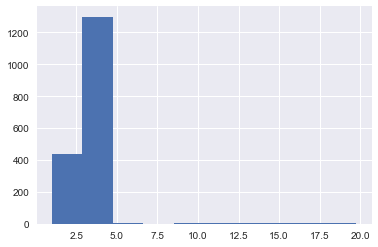

In [38]:
cacao.rating.hist()
cacao.rating.describe()

Как мы видим, большинство оценок распределены между 3 и 3.5 (медиана 3.25, 25-й перцентиль 3 и 75-й — 3.5), что позволяет сделать два предположения:

1. Скорее всего была использована пятибалльная шкала оценивания
2. В данных есть выбросы.

Давайте это проверим:

25-й перцентиль: 3.0, 75-й перцентиль: 3.5, IQR: 0.5,  Границы выбросов: [2.25, 4.25].


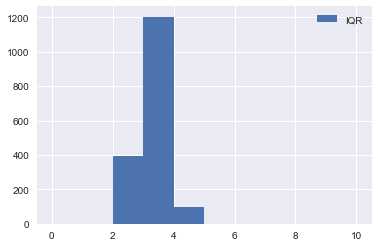

In [39]:
IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
cacao.rating.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
 
plt.legend();

Этот способ позволил нам отобрать экстремально низкие и экстремально высокие оценки. Отфильтруем данные:

In [40]:
cacao = cacao.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

### bean_type
Сразу заменим пропуски на None:

In [43]:
cacao.bean_type = cacao.bean_type.astype(str).apply(lambda x: None if x.strip() == '' else x)
print(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

                          bean_type
None                            829
Trinitario                      401
Criollo                         147
Forastero                        81
Forastero (Nacional)             50
Criollo, Trinitario              37
Blend                            36
Forastero (Arriba)               30
Criollo (Porcelana)              10
Trinitario, Criollo               9
Forastero (Parazinho)             8
Forastero (Arriba) ASS            5
Matina                            3
Nacional (Arriba)                 3
EET                               3
Beniano                           3
Amazon, ICS                       2
Trinitario, Forastero             2
Nacional                          2
Forastero (Catongo)               2
Criollo (Ocumare 61)              2
Amazon mix                        2
Trinitario (85% Criollo)          2
Criollo, Forastero                2
Criollo (Amarru)                  2
Forastero (Amelonado)             1
Trinitario (Amelonado)      

Мы видим, что есть строка со значением nan, надо заменить её на None для удобства. Также мы видим, что многие типы бобов указаны с пояснением, например "Criollo (Ocumare 67)", такие значения стоит привести к общему виду.

Также некоторые батончики сделаны из комбинации какао-бобов. Возможно, этот столбец для дальнейшего анализа нужно будет преобразовать через метод get_dummies(), однако сейчас мы делать этого не будем.

In [44]:
cacao.bean_type = cacao.bean_type.apply(lambda x: None if pd.isnull(x) else None if x == 'nan' 
                      else x if '(' not in x else x[:x.find('(')].strip())

In [45]:
print(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

                         bean_type
None                           829
Trinitario                     405
Forastero                      179
Criollo                        165
Criollo, Trinitario             37
Blend                           36
Trinitario, Criollo              9
Nacional                         5
EET                              3
Beniano                          3
Matina                           3
Criollo, Forastero               2
Amazon mix                       2
Trinitario, Forastero            2
Amazon, ICS                      2
Amazon                           1
Blend-Forastero,Criollo          1
Trinitario, Nacional             1
Trinitario, TCGA                 1
Criollo, +                       1
CCN51                            1
Forastero, Trinitario            1
Значений, встретившихся в столбце более 10 раз: 6
Уникальных значений: 22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
bean_type    16

Мы сократили количество уникальных значений в столбце до 21. Пустые значения заполнить не получится, так как есть пять самых популярных (10+ батончиков) сортов какао.

#### broad_origin

Задание 2.4.1

2 points possible (graded)
Самостоятельно обработайте пропуски в этом столбце, заменив их на None, и ответьте на вопросы:

Сколько уникальных значений содержит столбец?

In [62]:
cacao.broad_origin = cacao.broad_origin.apply(lambda x:   None if pd.isnull(x) else None if x.strip() == '' else None if x == 'nan' else x )

In [63]:
cacao.loc[:,['broad_origin']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
broad_origin    1630 non-null object
dtypes: object(1)
memory usage: 106.4+ KB


Сколько уникальных значений содержит столбец?

In [73]:
len(cacao.broad_origin.unique())

97

Сколько из них встречаются более 10 раз?

In [74]:

(cacao.broad_origin.value_counts()>10).sum()

25

В столбце много повторяющихся значений с различным написанием. 

In [75]:
cacao.broad_origin.unique()

array(['Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama', 'Madagascar',
       'Brazil', 'Ecuador', 'Colombia', 'Burma', 'Papua New Guinea',
       'Bolivia', 'Fiji', 'Mexico', 'Indonesia', 'Trinidad', 'Vietnam',
       'Nicaragua', 'Tanzania', 'Dominican Republic', 'Ghana', 'Belize',
       None, 'Jamaica', 'Honduras', 'Costa Rica', 'Guatemala', 'Haiti',
       'Congo', 'Philippines', 'Domincan Republic', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Grenada',
       'Sao Tome', 'Uganda', 'Martinique', 'Sao Tome & Principe',
       'Vanuatu', 'Australia', 'Liberia', 'Ecuador, Costa Rica',
       'West Africa', 'Hawaii', 'St. Lucia', 'Cost Rica, Ven',
       'Peru, Madagascar', 'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Trinidad-Tobago',
       'Peru, Ecuador, Venezuela', 'Venezuela, Dom

Исправляем это, написав дополнительную функцию:

In [77]:
def fix_countries(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = x.replace(' ', '')
    x = x.replace('/', ',') # Venezuela/ Ghana
    x = x.replace('&', ',')
    if '(' in x:
        x = x[:x.find('(')] #Peru(SMartin,Pangoa,nacional)
    x = x.replace('Guat.', 'Guatemala')
    
    if 'Ven' in x and 'Venezuela' not in x:
        x = x.replace('Venez', 'Venezuela') #Venez,Africa,Brasil,Peru,Mex
        x = x.replace('Ven,', 'Venezuela,') #Ven, Trinidad, Ecuador
        x = x.replace('Ven.', 'Venezuela') #Ven., Trinidad, Mad.
        if 'Ven' in x and 'Venezuela' not in x:
            x = x.replace('Ven', 'Venezuela')
        
    x = x.replace('Dom.Rep.', 'DomincanRepublic')
    x = x.replace('DR', 'DomincanRepublic')
    x = x.replace('Dom.Rep', 'DomincanRepublic')
    x = x.replace('D.R.', 'DomincanRepublic')
    x = x.replace('DominicanRep.', 'DomincanRepublic')
    x = x.replace('Domin.Rep', 'DomincanRepublic')
    x = x.replace('Domin.Re', 'DomincanRepublic')
    
    if 'Jam' in x and 'Jamaica' not in x:
        x = x.replace('Jam', 'Jamaica')
        
    if 'Mad.' in x and 'Madagascar' not in x:
        x = x.replace('Mad.', 'Madagascar')
    elif 'Mad' in x and 'Madagascar' not in x:
        x = x.replace('Mad', 'Madagascar')
    elif 'Ma' in x and 'Madagascar' not in x:
        x = x.replace('Ma', 'Madagascar')
        
    if 'Hait' in x and 'Haiti' not in x:
        x = x.replace('Hait', 'Haiti')
        
    if 'Per' in x and 'Peru'  not in x:
        x = x.replace('Per', 'Peru')
    
    x = x.replace('Nic.', 'Nicaragua')

    x = x.replace('Gre.', 'Grenada')
    
    x = x.replace('PNG', 'PapuaNewGuinea')
    
    if 'Mex' in x and 'Mexico' not in x:
        x = x.replace('Mex', 'Mexico')
        
    x = x.replace('Haw.', 'Hawaii')
    
    x = x.replace('Ecuad.', 'Ecuador')
    x = x.replace('Ecu.', 'Ecuador')
    
    return x

In [78]:
cacao.broad_origin = cacao.broad_origin.apply(fix_countries).sort_values()

Посмотрим, как изменились данные:

In [80]:
print(pd.DataFrame(cacao.broad_origin.value_counts()))
print('Значений, упомянутых более 10 раз:', (cacao.broad_origin.value_counts()>10).sum())
print("Уникальных значений:", cacao.broad_origin.nunique())
cacao.loc[:, ['broad_origin']].info()

                                                broad_origin
Venezuela                                                202
Ecuador                                                  179
Peru                                                     160
Madagascar                                               138
DominicanRepublic                                        135
Brazil                                                    57
Nicaragua                                                 57
Bolivia                                                   53
Belize                                                    49
PapuaNewGuinea                                            41
Vietnam                                                   38
Colombia                                                  38
CostaRica                                                 36
Trinidad                                                  32
Ghana                                                     31
Tanzania                

Мы сократили количество уникальных значений (хотя и всего на 4). Однако такая трансформация в последствии поможет нам преобразовать данные через метод get_dummies(). Пропущенные значения заполнить не получится, так как данных всё ещё достаточно мало.

### 2.5. Корреляционный анализ

Выясним, какие столбцы коррелируют с оценкой шоколадных батончиков. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

Для быстрого построения графиков зависимости переменных можно воспользоваться функцией pairplot из модуля seaborn:

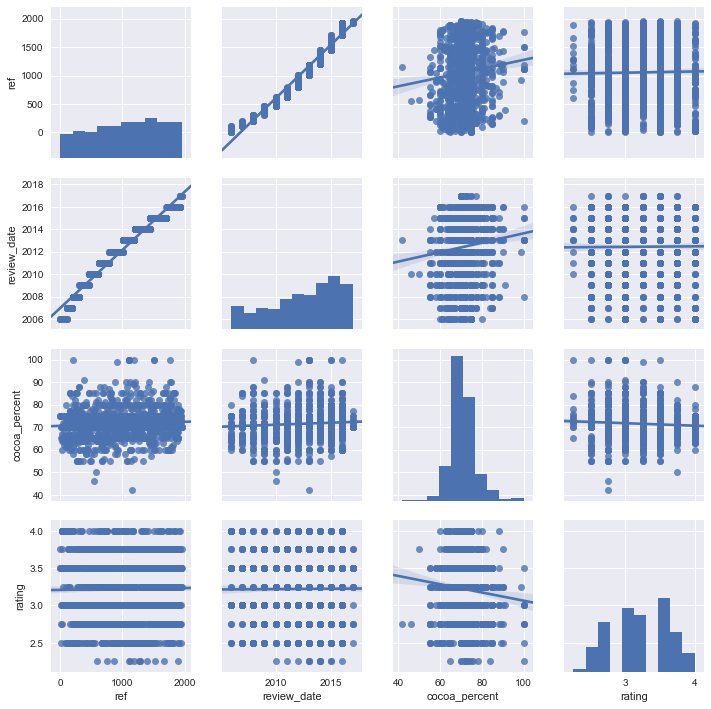

In [83]:
sns.pairplot(cacao, kind = 'reg')

Используем для наглядности матрицу корреляций:

In [84]:
cacao.corr()

,ref,review_date,cocoa_percent,rating
ref,1.000000,0.984913,0.083765,0.016189
review_date,0.984913,1.000000,0.086523,0.006703
cocoa_percent,0.083765,0.086523,1.000000,-0.078156
rating,0.016189,0.006703,-0.078156,1.000000


Так как переменные review_date и ref скоррелированы почти полностью, одну переменную можно исключить. Пусть это будет переменная REF.

Останутся две слабоскоррелированные с рейтингом переменные: cocoa_percent и review_date.

Интересно, что положительная корреляция параметра review_date и rating может говорить как о том, что со временем батончики действительно становятся лучше, так и о том, что рейтинги просто завышаются.

#### 2.6. Анализ номинативных переменных


Очевидно, что для номинативных переменных использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

Номинативные переменные, которые осталось рассмотреть: company, specific_origin, company_location, bean_type, broad_origin.

Так как уникальных значений в столбцах достаточно много, будем брать в рассмотрение по, например, 10 самых частотных.

In [85]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

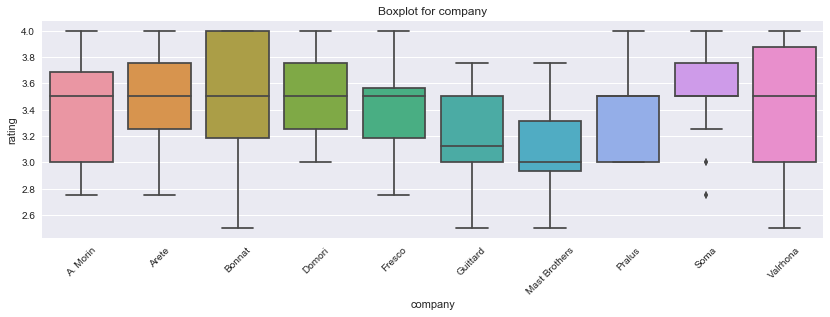

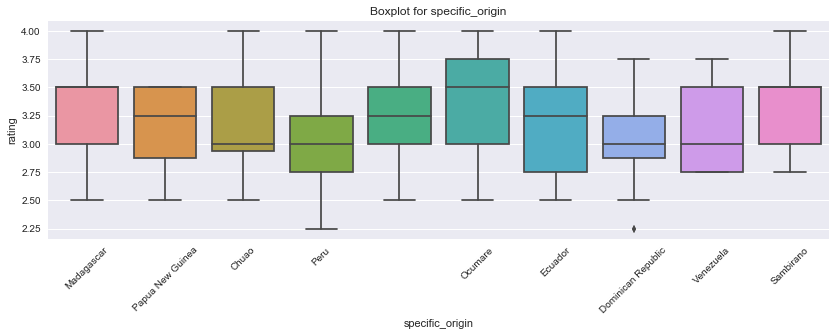

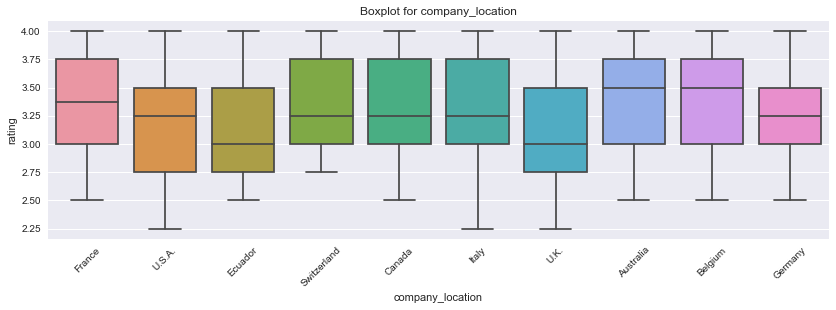

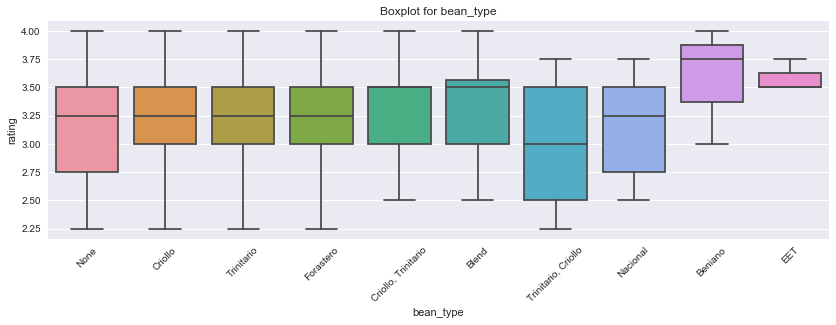

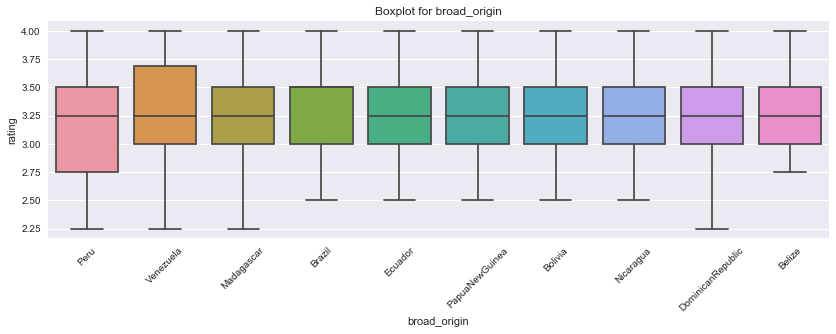

In [86]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot(col)

In [98]:
#print(cacao)
from IPython.display import display
display(cacao)
cacao

,company,specific_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_origin
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,None,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,None,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,None,Peru
5,A. Morin,Carenero,1315,2014,70.0,France,2.75,Criollo,Venezuela
6,A. Morin,Cuba,1315,2014,70.0,France,3.50,None,Cuba
8,None,Puerto Cabello,1319,2014,70.0,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,70.0,France,4.00,None,Peru
10,A. Morin,Panama,1011,2013,70.0,France,2.75,None,Panama
11,A. Morin,Madagascar,1011,2013,70.0,France,3.00,Criollo,Madagascar
12,A. Morin,Brazil,1011,2013,70.0,France,3.25,None,Brazil


,company,specific_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_origin
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,None,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,None,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,None,Peru
5,A. Morin,Carenero,1315,2014,70.0,France,2.75,Criollo,Venezuela
6,A. Morin,Cuba,1315,2014,70.0,France,3.50,None,Cuba
8,None,Puerto Cabello,1319,2014,70.0,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,70.0,France,4.00,None,Peru
10,A. Morin,Panama,1011,2013,70.0,France,2.75,None,Panama
11,A. Morin,Madagascar,1011,2013,70.0,France,3.00,Criollo,Madagascar
12,A. Morin,Brazil,1011,2013,70.0,France,3.25,None,Brazil


По графикам похоже, что все параметры, кроме broad_origin, могут влиять на оценку батончика. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:

In [99]:
def get_stat_dif(column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'rating'], 
                        cacao.loc[cacao.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [100]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки company
Найдены статистически значимые различия для колонки specific_origin
Найдены статистически значимые различия для колонки company_location


* Найдены статистически значимые различия для колонки company
* Найдены статистически значимые различия для колонки specific_origin
* Найдены статистически значимые различия для колонки company_location

Как мы видим, серьёзно отличаются три параметра: company,  specific_origin и  company_location. Оставим эти переменные в датасете для дальнейшего построения модели. Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это: company, specific_origin, company_location, review_date, cocoa_percent.

In [101]:
cacao_for_model = cacao.loc[:, ['company', 'specific_origin', 'company_location', 'review_date', 'cocoa_percent']]
cacao_for_model.head()

,company,specific_origin,company_location,review_date,cocoa_percent
1,A. Morin,Kpime,France,2015,70.0
3,A. Morin,Akata,France,2015,70.0
4,A. Morin,Quilla,France,2015,70.0
5,A. Morin,Carenero,France,2014,70.0
6,A. Morin,Cuba,France,2014,70.0


## 2.7. Выводы

В результате EDA для анализа влияния параметров шоколада на экспертную оценку шоколадных батончиков были получены следующие выводы:

* В данных достаточно мало пустых значений, только столбец bean_type был заполнен в малом количестве случаев.
* Выбросы найдены только в столбцах с рейтингом и содержанием какао в шоколаде батончиков, что позволяет сделать вывод о том, что данные достаточно чистые.
* Положительная корреляция параметра review_date и rating может говорить о том, что с годами рейтинги потихоньку завышаются, либо батончики становятся лучше.
* Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это company, specific_origin, company_location, review_date и cocoa_percent.